# Wannierization using Wannier.jl or Wannier90

DFTK features an interface with the programs
[Wannier.jl](https://wannierjl.org) and [Wannier90](http://www.wannier.org/),
in order to compute maximally-localized Wannier functions (MLWFs)
from an initial self consistent field calculation.
All processes are handled by calling the routine `Wannier.Model` (for Wannier.jl)
or `run_wannier90` (for Wannier90).

> **No guarantees on Wannier interface**
>
> This code is at an early stage and has so far not been fully tested.
> Bugs are likely and we welcome issues in case you find any!

This example shows how to obtain the MLWFs corresponding
to the first five bands of graphene. Since the bands 2 to 11 are entangled,
15 bands are first computed to obtain 5 MLWFs by a disantanglement procedure.

In [1]:
using DFTK
using Plots
using Unitful
using UnitfulAtomic

d = 10u"Å"
a = 2.641u"Å"  # Graphene Lattice constant
lattice = [a  -a/2    0;
           0  √3*a/2  0;
           0     0    d]

C = ElementPsp(:C, load_psp("hgh/pbe/c-q4"))
atoms     = [C, C]
positions = [[0.0, 0.0, 0.0], [1//3, 2//3, 0.0]]
model = model_DFT(lattice, atoms, positions; functionals=PBE())
basis = PlaneWaveBasis(model; Ecut=15, kgrid=[5, 5, 1])
nbandsalg = AdaptiveBands(basis.model; n_bands_converge=15)
scfres = self_consistent_field(basis; nbandsalg, tol=1e-5);

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -11.14942591637                   -0.67    8.6    578ms
  2   -11.15007217591       -3.19       -1.40    1.2    253ms
  3   -11.15010730712       -4.45       -2.77    3.4    307ms
  4   -11.15010938078       -5.68       -3.31    4.2    396ms
  5   -11.15010942902       -7.32       -4.26    3.0    299ms
  6   -11.15010943370       -8.33       -4.93    4.2    390ms
  7   -11.15010943375      -10.29       -5.49    3.2    375ms


Plot bandstructure of the system

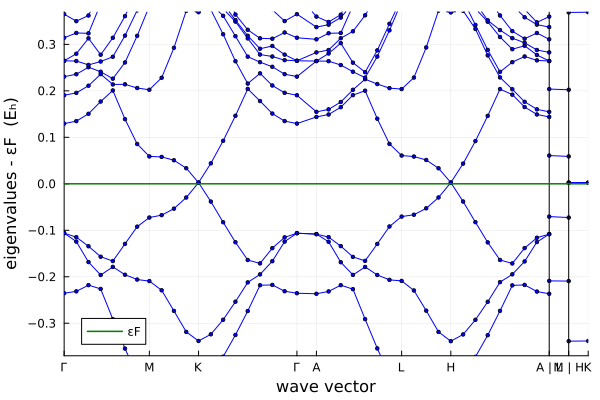

In [2]:
bands = compute_bands(scfres; kline_density=10)
plot_bandstructure(bands)

## Wannierization with Wannier.jl

Now we use the `Wannier.Model` routine to generate a Wannier.jl model
that can be used to perform the wannierization procedure.
For now, this model generation produces file in the Wannier90 convention,
where all files are named with the same prefix and only differ by
their extensions. By default all generated input and output files are stored
in the subfolder "wannierjl" under the prefix "wannier" (i.e. "wannierjl/wannier.win",
"wannierjl/wannier.wout", etc.). A different file prefix can be given with the
keyword argument `fileprefix` as shown below.

We now produce a simple Wannier model for 5 MLFWs.

For a good MLWF, we need to provide initial projections that resemble the expected shape
of the Wannier functions.
Here we will use:
- 3 bond-centered 2s hydrogenic orbitals for the expected σ bonds
- 2 atom-centered 2pz hydrogenic orbitals for the expected π bands

In [3]:
using Wannier # Needed to make Wannier.Model available

From chemical intuition, we know that the bonds with the lowest energy are:
  - the 3 σ bonds,
  - the π and π* bonds.
We provide relevant initial projections to help Wannierization
converge to functions with a similar shape.

In [4]:
s_guess(center)  = DFTK.HydrogenicWannierProjection(center, 2, 0, 0, C.Z)
pz_guess(center) = DFTK.HydrogenicWannierProjection(center, 2, 1, 0, C.Z)
projections = [
    # Note: fractional coordinates for the centers!
    # 3 bond-centered 2s hydrogenic orbitals to imitate σ bonds
    s_guess((positions[1] + positions[2]) / 2),
    s_guess((positions[1] + positions[2] + [0, -1, 0]) / 2),
    s_guess((positions[1] + positions[2] + [-1, -1, 0]) / 2),
    # 2 atom-centered 2pz hydrogenic orbitals
    pz_guess(positions[1]),
    pz_guess(positions[2]),
]

5-element Vector{DFTK.HydrogenicWannierProjection}:
 DFTK.HydrogenicWannierProjection([0.16666666666666666, 0.3333333333333333, 0.0], 2, 0, 0, 6)
 DFTK.HydrogenicWannierProjection([0.16666666666666666, -0.16666666666666669, 0.0], 2, 0, 0, 6)
 DFTK.HydrogenicWannierProjection([-0.33333333333333337, -0.16666666666666669, 0.0], 2, 0, 0, 6)
 DFTK.HydrogenicWannierProjection([0.0, 0.0, 0.0], 2, 1, 0, 6)
 DFTK.HydrogenicWannierProjection([0.3333333333333333, 0.6666666666666666, 0.0], 2, 1, 0, 6)

Wannierize:

In [5]:
wannier_model = Wannier.Model(scfres;
    fileprefix="wannier/graphene",
    n_bands=scfres.n_bands_converge,
    n_wannier=5,
    projections,
    dis_froz_max=ustrip(auconvert(u"eV", scfres.εF))+1) # maximum frozen window, for example 1 eV above Fermi level

[ Info: Reading win file: wannier/graphene.win
  num_wann  = 5
  num_bands = 15
  mp_grid   = 5 5 1

b-vector shell   1    weight =  1.10422
    1      -0.47582   -0.27471    0.00000
    2       0.47582    0.27471    0.00000
    3       0.00000   -0.54943    0.00000
    4       0.00000    0.54943    0.00000
    5       0.47582   -0.27471    0.00000
    6      -0.47582    0.27471    0.00000
b-vector shell   2    weight =  1.26651
    1       0.00000    0.00000   -0.62832
    2       0.00000    0.00000    0.62832

Finite difference condition satisfied

[ Info: Reading win file: wannier/graphene.win
  num_wann  = 5
  num_bands = 15
  mp_grid   = 5 5 1

b-vector shell   1    weight =  1.10422
    1      -0.47582   -0.27471    0.00000
    2       0.47582    0.27471    0.00000
    3       0.00000   -0.54943    0.00000
    4       0.00000    0.54943    0.00000
    5       0.47582   -0.27471    0.00000
    6      -0.47582    0.27471    0.00000
b-vector shell   2    weight =  1.26651
    1     

lattice: Å
  a1:  2.64100  0.00000  0.00000
  a2: -1.32050  2.28717  0.00000
  a3:  0.00000  0.00000 10.00000

atoms: fractional
   C:  0.00000  0.00000  0.00000
   C:  0.33333  0.66667  0.00000

n_bands: 15
n_wann : 5
kgrid  : 5 5 1
n_kpts : 25
n_bvecs: 8

b-vectors:
         [bx, by, bz] / Å⁻¹                weight
  1      -0.47582   -0.27471    0.00000    1.10422
  2       0.47582    0.27471    0.00000    1.10422
  3       0.00000   -0.54943    0.00000    1.10422
  4       0.00000    0.54943    0.00000    1.10422
  5       0.47582   -0.27471    0.00000    1.10422
  6      -0.47582    0.27471    0.00000    1.10422
  7       0.00000    0.00000   -0.62832    1.26651
  8       0.00000    0.00000    0.62832    1.26651

Once we have the `wannier_model`,
we can use the functions in the Wannier.jl package:

Compute MLWF:

In [6]:
U = disentangle(wannier_model, max_iter=200);

[ Info: Initial spread
  WF     center [rx, ry, rz]/Å              spread/Å²
   1     0.00000     0.76239     0.00000     0.62113
   2     0.66025    -0.38120     0.00000     0.62113
   3    -0.66025    -0.38120    -0.00000     0.62113
   4    -0.00000    -0.00000    -0.00000     1.19369
   5    -0.00000     1.52478     0.00000     1.19369
Sum spread: Ω = ΩI + Ω̃, Ω̃ = ΩOD + ΩD
   ΩI  =     3.81157
   Ω̃   =     0.43920
   ΩOD =     0.43823
   ΩD  =     0.00097
   Ω   =     4.25077


[ Info: Initial spread (with states freezed)
  WF     center [rx, ry, rz]/Å              spread/Å²
   1     0.00000     0.76239     0.00000     0.64218
   2     0.66025    -0.38120     0.00000     0.64218
   3    -0.66025    -0.38120    -0.00000     0.64218
   4    -0.00000     0.00000    -0.00000     1.13078
   5     0.00000     1.52478     0.00000     1.13078
Sum spread: Ω = ΩI + Ω̃, Ω̃ = ΩOD + ΩD
   ΩI  =     3.46548
   Ω̃   =     0.72262
   ΩOD =     0.71487
   ΩD  =     0.00775
   Ω   =     4.18810




 * Status: success

 * Candidate solution
    Final objective value:     3.765730e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.07e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.07e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.58e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.86e-10 ≤ 1.0e-07
    |g(x)|                 = 1.36e-06 ≤ 1.0e-05

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    7
    f(x) calls:    17
    ∇f(x) calls:   18


Inspect localization before and after Wannierization:

In [7]:
omega(wannier_model)
omega(wannier_model, U)

  WF     center [rx, ry, rz]/Å              spread/Å²
   1    -0.00000     0.76239     0.00000     0.64174
   2     0.66025    -0.38120     0.00000     0.64174
   3    -0.66025    -0.38120    -0.00000     0.64174
   4    -0.00000     0.00000    -0.00000     0.92025
   5    -0.00000     1.52478     0.00000     0.92025
Sum spread: Ω = ΩI + Ω̃, Ω̃ = ΩOD + ΩD
   ΩI  =     3.02222
   Ω̃   =     0.74351
   ΩOD =     0.73886
   ΩD  =     0.00465
   Ω   =     3.76573


Build a Wannier interpolation model:

In [8]:
kpath = irrfbz_path(model)
interp_model = Wannier.InterpModel(wannier_model; kpath=kpath)


recip_lattice: Å⁻¹
  a1:  2.37909  1.37357 -0.00000
  a2:  0.00000  2.74714  0.00000
  a3:  0.00000 -0.00000  0.62832
kgrid  : 5 5 1
n_kpts : 25

lattice: Å
  a1:  2.64100  0.00000  0.00000
  a2: -1.32050  2.28717  0.00000
  a3:  0.00000  0.00000 10.00000
grid    = 5 5 1
n_rvecs = 31
using MDRS interpolation

KPath{3} (6 points, 3 paths, 12 points in paths):
 points: :M => [0.5, 0.0, 0.0]
         :A => [0.0, 0.0, 0.5]
         :H => [0.333333, 0.333333, 0.5]
         :K => [0.333333, 0.333333, 0.0]
         :Γ => [0.0, 0.0, 0.0]
         :L => [0.5, 0.0, 0.5]
  paths: [:Γ, :M, :K, :Γ, :A, :L, :H, :A]
         [:L, :M]
         [:H, :K]
  basis: [1.258962, 0.726862, -0.0]
         [0.0, 1.453724, 0.0]
         [0.0, -0.0, 0.332492]

And so on...
Refer to the Wannier.jl documentation for further examples.

(Delete temporary files when done.)

In [9]:
rm("wannier", recursive=true)

### Custom initial guesses

We can also provide custom initial guesses for Wannierization,
by passing a callable function in the `projections` array.
The function receives the basis and a list of points
(fractional coordinates in reciprocal space),
and returns the Fourier transform of the initial guess function evaluated at each point.

For example, we could use Gaussians for the σ and pz guesses with the following code:

In [10]:
s_guess(center) = DFTK.GaussianWannierProjection(center)
function pz_guess(center)
    # Approximate with two Gaussians offset by 0.5 Å from the center of the atom
    offset = model.inv_lattice * [0, 0, austrip(0.5u"Å")]
    center1 = center + offset
    center2 = center - offset
    # Build the custom projector
    (basis, ps) -> DFTK.GaussianWannierProjection(center1)(basis, ps) - DFTK.GaussianWannierProjection(center2)(basis, ps)
end
# Feed to Wannier via the `projections` as before...

pz_guess (generic function with 1 method)

This example assumes that Wannier.jl version 0.3.2 is used,
and may need to be updated to accommodate for changes in Wannier.jl.

Note: Some parameters supported by Wannier90 may have to be passed to Wannier.jl differently,
for example the max number of iterations is passed to `disentangle` in Wannier.jl,
but as `num_iter` to `run_wannier90`.

## Wannierization with Wannier90

We can use the `run_wannier90` routine to generate all required files and perform the wannierization procedure:

In [11]:
using wannier90_jll  # Needed to make run_wannier90 available
run_wannier90(scfres;
              fileprefix="wannier/graphene",
              n_wannier=5,
              projections,
              num_print_cycles=25,
              num_iter=200,
              #
              dis_win_max=19.0,
              dis_froz_max=ustrip(auconvert(u"eV", scfres.εF))+1, # 1 eV above Fermi level
              dis_num_iter=300,
              dis_mix_ratio=1.0,
              #
              wannier_plot=true,
              wannier_plot_format="cube",
              wannier_plot_supercell=5,
              write_xyz=true,
              translate_home_cell=true,
             );

As can be observed standard optional arguments for the disentanglement
can be passed directly to `run_wannier90` as keyword arguments.

(Delete temporary files.)

In [12]:
rm("wannier", recursive=true)